# Packages

In [299]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from py_vollib.black_scholes_merton import black_scholes_merton as black_scholes_merton
from py_vollib.black_scholes_merton.greeks.numerical import delta, theta, vega, rho, gamma
from scipy.interpolate import griddata

import datetime
import bisect

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')
sns.set_style('darkgrid')

# Testing with AAPL

In [141]:
aapl = yf.Ticker("AAPL")
aapl.options


('2025-02-28',
 '2025-03-07',
 '2025-03-14',
 '2025-03-21',
 '2025-03-28',
 '2025-04-04',
 '2025-04-17',
 '2025-05-16',
 '2025-06-20',
 '2025-07-18',
 '2025-08-15',
 '2025-09-19',
 '2025-10-17',
 '2025-12-19',
 '2026-01-16',
 '2026-03-20',
 '2026-06-18',
 '2026-12-18',
 '2027-01-15',
 '2027-06-17')

In [142]:
optionchain = aapl.option_chain('2025-04-04')
optionchain.calls.head(5)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250404C00100000,2025-02-20 14:30:04+00:00,100.0,146.58,139.25,140.05,0.0,0.0,NaN,0,1.386722,True,REGULAR,USD
1,AAPL250404C00140000,2025-02-24 19:37:23+00:00,140.0,108.87,99.70,100.35,0.0,0.0,1.0,2,0.977295,True,REGULAR,USD
2,AAPL250404C00180000,2025-02-18 14:30:07+00:00,180.0,65.75,59.95,60.85,0.0,0.0,NaN,1,0.617924,True,REGULAR,USD
3,AAPL250404C00185000,2025-02-14 18:08:42+00:00,185.0,60.83,55.15,55.95,0.0,0.0,NaN,2,0.584965,True,REGULAR,USD
4,AAPL250404C00190000,2025-02-20 16:26:53+00:00,190.0,57.40,50.15,51.10,0.0,0.0,NaN,2,0.543706,True,REGULAR,USD


# Get Option Chain

In [263]:
def get_rfr_from_box_combo(date_df):
    underlying = date_df["underlying"].iloc[0]
    strikes = sorted(date_df["strike"].unique())

    n = len(strikes)
    if n < 3:
        lower = 0
        upper = n - 1
    else:
        index = bisect.bisect_left(strikes, underlying)
        lower, upper = 0, 0
        if index == 0: 
            lower = 0
            upper = 2
        elif index == n: 
            lower = n - 3
            upper = index - 1
        else:
            lower = index - 1
            upper = index + 1
    
    lower_strike = strikes[lower]
    upper_strike = strikes[upper]
    box_combo_price = date_df.query("is_call == 1 & strike == @lower_strike")["midpoint"].item() \
                        - date_df.query("is_call == 1 & strike == @upper_strike")["midpoint"].item() \
                        - date_df.query("is_call == 0 & strike == @lower_strike")["midpoint"].item() \
                        + date_df.query("is_call == 0 & strike == @upper_strike")["midpoint"].item()
    time_to_expiry = date_df.iloc[0]["time_to_expiry"].item()
    box_rate = -1 / time_to_expiry * np.log((box_combo_price) / (upper_strike - lower_strike))

    return box_rate

# def get_SPIBOR(): TODO, RFR from only box rate seems wrong


def calculate_greeks(date_df, current_price, dividend_yield, expiry_date):
    date_df["midpoint"] = (date_df["bid"] + date_df["ask"]) / 2
    date_df["underlying"] = current_price
    date_df["dividend_yield"] = dividend_yield / 100
    datetime_expiry_date = datetime.datetime.strptime(expiry_date, "%Y-%m-%d")
    datetime_expiry_date = datetime_expiry_date.replace(hour=16)
    diff_seconds = (datetime_expiry_date - datetime.datetime.today()).total_seconds()
    date_df["time_to_expiry"] = diff_seconds / 31536000
    date_df["averageImpliedVol"] = date_df.groupby('strike')['impliedVolatility'].transform('mean')
    # date_df["market_implied_rfr"] = get_rfr_from_box_combo(date_df)
    date_df["market_implied_rfr"] = 1.04113**(diff_seconds / 31536000) - 1
    # print(f'DEBUG: Greek params: midpoint = {date_df.iloc[0]["midpoint"]}, underlying = {date_df.iloc[0]["underlying"]}, \
    #       dividend_yield = {date_df.iloc[0]["dividend_yield"]}, time_to_expiry = {date_df.iloc[0]["time_to_expiry"]}\
    #         market_implied_rfr = {date_df.iloc[0]["market_implied_rfr"]}')
    date_df["delta"] = date_df.apply(
        lambda row: delta(
            'c' if row["is_call"] == 1 else 'p',
            row["underlying"],
            row["strike"],
            row["time_to_expiry"],
            row["market_implied_rfr"],
            row["averageImpliedVol"],
            row["dividend_yield"]
        ),
        axis=1
    )
    date_df["gamma"] = date_df.apply(
        lambda row: gamma(
            'c' if row["is_call"] == 1 else 'p',
            row["underlying"],
            row["strike"],
            row["time_to_expiry"],
            row["market_implied_rfr"],
            row["averageImpliedVol"],
            row["dividend_yield"]
        ),
        axis=1
    )
    date_df["theta"] = date_df.apply(
        lambda row: theta(
            'c' if row["is_call"] == 1 else 'p',
            row["underlying"],
            row["strike"],
            row["time_to_expiry"],
            row["market_implied_rfr"],
            row["averageImpliedVol"],
            row["dividend_yield"]
        ),
        axis=1
    )
    date_df["vega"] = date_df.apply(
        lambda row: vega(
            'c' if row["is_call"] == 1 else 'p',
            row["underlying"],
            row["strike"],
            row["time_to_expiry"],
            row["market_implied_rfr"],
            row["averageImpliedVol"],
            row["dividend_yield"]
        ),
        axis=1
    )
    date_df["rho"] = date_df.apply(
        lambda row: rho(
            'c' if row["is_call"] == 1 else 'p',
            row["underlying"],
            row["strike"],
            row["time_to_expiry"],
            row["market_implied_rfr"],
            row["averageImpliedVol"],
            row["dividend_yield"]
        ),
        axis=1
    )
       
    return date_df

def get_option_chain(ticker):
    yf_ticker = yf.Ticker(ticker)
    current_price = yf_ticker.history(period="1d")['Close'].iloc[-1]
    dividend_yield = yf_ticker.info.get("dividendYield")

    expiry_dates = yf_ticker.options
    to_ret_dict = {}
    for date in expiry_dates:
        print(f"Grabbing {date}")
        try:
            option_chain = yf_ticker.option_chain(date)
            call_df = option_chain.calls
            call_df["is_call"] = 1
            put_df = option_chain.puts
            put_df["is_call"] = 0
            date_df = pd.concat([call_df, put_df])
            date_df = calculate_greeks(date_df, current_price, dividend_yield, date)
            to_ret_dict[date] = date_df
        except KeyError as e:
            print(f"Failed grabbing {date} - exception = {e}")
    
    return to_ret_dict

In [264]:
aapl_option_chain_dict = get_option_chain("AAPL")

Grabbing 2025-02-28
Grabbing 2025-03-07
Grabbing 2025-03-14
Grabbing 2025-03-21
Grabbing 2025-03-28
Grabbing 2025-04-04
Grabbing 2025-04-17
Grabbing 2025-05-16
Grabbing 2025-06-20
Grabbing 2025-07-18
Grabbing 2025-08-15
Grabbing 2025-09-19
Grabbing 2025-10-17
Grabbing 2025-12-19
Grabbing 2026-01-16
Grabbing 2026-03-20
Grabbing 2026-06-18
Grabbing 2026-12-18
Grabbing 2027-01-15
Grabbing 2027-06-17


In [265]:
print(aapl_option_chain_dict.keys())

dict_keys(['2025-02-28', '2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-04-04', '2025-04-17', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17'])


In [266]:
test_df = aapl_option_chain_dict["2025-04-04"]
display(test_df)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,is_call,midpoint,underlying,dividend_yield,time_to_expiry,averageImpliedVol,market_implied_rfr,delta,gamma,theta,vega,rho
0,AAPL250404C00100000,2025-02-20 14:30:04+00:00,100.0,146.58,137.90,138.45,0.000000,0.000000,NaN,0,1.525393,True,REGULAR,USD,1,138.175,237.169998,0.0042,0.09621,1.245119,0.003885,9.920319e-01,2.277812e-04,-2.477599e-02,1.535014e-02,9.419936e-02
1,AAPL250404C00140000,2025-02-24 19:37:23+00:00,140.0,108.87,98.10,98.85,0.000000,0.000000,1.0,2,1.039556,True,REGULAR,USD,1,98.475,237.169998,0.0042,0.09621,0.868412,0.003885,9.813639e-01,7.005073e-04,-3.864491e-02,3.292349e-02,1.300366e-01
2,AAPL250404C00180000,2025-02-27 19:32:53+00:00,180.0,61.36,58.65,59.25,0.000000,0.000000,1.0,2,0.657962,True,REGULAR,USD,1,58.950,237.169998,0.0042,0.09621,0.559941,0.003885,9.526238e-01,2.381596e-03,-5.609379e-02,7.216384e-02,1.615714e-01
3,AAPL250404C00185000,2025-02-14 18:08:42+00:00,185.0,60.83,53.65,54.30,0.000000,0.000000,NaN,2,0.608891,True,REGULAR,USD,1,53.975,237.169998,0.0042,0.09621,0.521001,0.003885,9.467701e-01,2.810970e-03,-5.745658e-02,7.924862e-02,1.649930e-01
4,AAPL250404C00190000,2025-02-20 16:26:53+00:00,190.0,57.40,48.75,49.60,0.000000,0.000000,NaN,2,0.574711,True,REGULAR,USD,1,49.175,237.169998,0.0042,0.09621,0.490362,0.003885,9.370824e-01,3.409556e-03,-6.195333e-02,9.046812e-02,1.674661e-01
5,AAPL250404C00195000,2025-02-26 16:25:02+00:00,195.0,48.38,43.90,44.60,0.000000,0.000000,1.0,5,0.529546,True,REGULAR,USD,1,44.250,237.169998,0.0042,0.09621,0.454595,0.003885,9.273059e-01,4.115025e-03,-6.443549e-02,1.012191e-01,1.699477e-01
6,AAPL250404C00200000,2025-02-25 16:51:11+00:00,200.0,50.51,39.05,39.45,0.000000,0.000000,1.0,3,0.492437,True,REGULAR,USD,1,39.250,237.169998,0.0042,0.09621,0.423956,0.003885,9.129973e-01,5.058914e-03,-6.912103e-02,1.160449e-01,1.713241e-01
7,AAPL250404C00205000,2025-02-28 16:03:26+00:00,205.0,33.55,34.45,34.85,-8.010002,-19.273344,5.0,1,0.465459,True,REGULAR,USD,1,34.650,237.169998,0.0042,0.09621,0.400336,0.003885,8.913604e-01,6.310313e-03,-7.717064e-02,1.366821e-01,1.709013e-01
8,AAPL250404C00210000,2025-02-27 20:53:33+00:00,210.0,28.10,29.65,30.10,-1.920000,-6.395736,1.0,30,0.426153,True,REGULAR,USD,1,29.875,237.169998,0.0042,0.09621,0.370368,0.003885,8.674989e-01,7.849605e-03,-8.240486e-02,1.572922e-01,1.699899e-01
9,AAPL250404C00215000,2025-02-26 20:58:29+00:00,215.0,27.55,25.15,25.45,0.000000,0.000000,51.0,42,0.389044,True,REGULAR,USD,1,25.300,237.169998,0.0042,0.09621,0.343085,0.003885,8.349163e-01,9.821551e-03,-8.874192e-02,1.823087e-01,1.669687e-01


# Get Straddle View

In [291]:
def get_straddle_df(option_chain_df):
    to_ret = pd.DataFrame()
    to_ret["strike"] = option_chain_df["strike"].unique()
    call_df = option_chain_df.query("is_call == 1")
    to_ret = to_ret.merge(call_df, how="left", on="strike")
    cols_to_drop = ["lastTradeDate", "contractSymbol", "lastPrice", "change", "percentChange",\
                    "contractSize","currency", "is_call", "underlying", "dividend_yield", "time_to_expiry", "market_implied_rfr", "averageImpliedVol"]
    cols_to_rename = {"bid" : "call_bid", "ask" : "call_ask", "volume" : "call_volume", "openInterest" : "call_openInterest", "midpoint" : "call_midpoint", "inTheMoney" : "call_inTheMoney",\
                    "impliedVolatility" : "call_IV", "delta" : "call_delta", "gamma" : "call_gamma", "theta" : "call_theta", "vega" : "call_vega", "rho" : "call_rho"}
    to_ret.drop(columns=cols_to_drop, inplace=True)
    to_ret.rename(columns=cols_to_rename, inplace=True)

    put_df = option_chain_df.query("is_call == 0")
    to_ret = to_ret.merge(put_df, how="left", on="strike")
    cols_to_drop = ["lastTradeDate", "contractSymbol", "lastPrice", "change", "percentChange",\
                    "contractSize","currency", "is_call", "underlying", "dividend_yield", "time_to_expiry", "market_implied_rfr", "averageImpliedVol"]
    cols_to_rename = {"bid" : "put_bid", "ask" : "put_ask", "volume" : "put_volume", "openInterest" : "put_openInterest", "midpoint" : "put_midpoint", "inTheMoney" : "put_inTheMoney",\
                    "impliedVolatility" : "put_IV", "delta" : "put_delta", "gamma" : "put_gamma", "theta" : "put_theta", "vega" : "put_vega", "rho" : "put_rho"}
    to_ret.drop(columns=cols_to_drop, inplace=True)
    to_ret.rename(columns=cols_to_rename, inplace=True)

    call_columns = [col for col in to_ret.columns if 'call' in col.lower()]
    call_columns.reverse()
    put_columns = [col for col in to_ret.columns if 'call' not in col.lower()]
    to_ret = to_ret[call_columns + put_columns]

    return to_ret

In [293]:
straddle_df = get_straddle_df(test_df)
straddle_df

,call_rho,call_vega,call_theta,call_gamma,call_delta,call_midpoint,call_inTheMoney,call_IV,call_openInterest,call_volume,call_ask,call_bid,strike,put_bid,put_ask,put_volume,put_openInterest,put_IV,put_inTheMoney,put_midpoint,put_delta,put_gamma,put_theta,put_vega,put_rho
0,9.419936e-02,1.535014e-02,-2.477599e-02,2.277812e-04,9.920319e-01,138.175,True,1.525393,0.0,NaN,138.45,137.90,100.0,0.02,0.04,NaN,3.0,0.964844,False,0.030,-0.007564,2.277817e-04,-0.026440,1.535014e-02,-0.001974
1,1.300366e-01,3.292349e-02,-3.864491e-02,7.005073e-04,9.813639e-01,98.475,True,1.039556,2.0,1.0,98.85,98.10,140.0,0.09,0.12,1.0,4.0,0.697269,False,0.105,-0.018232,7.005075e-04,-0.039883,3.292349e-02,-0.004607
2,1.615714e-01,7.216384e-02,-5.609379e-02,2.381596e-03,9.526238e-01,58.950,True,0.657962,2.0,1.0,59.25,58.65,180.0,0.30,0.33,12.0,25.0,0.461919,False,0.315,-0.046972,2.381596e-03,-0.056906,7.216384e-02,-0.011541
3,1.649930e-01,7.924862e-02,-5.745658e-02,2.810970e-03,9.467701e-01,53.975,True,0.608891,2.0,NaN,54.30,53.65,185.0,0.35,0.38,14.0,30.0,0.433111,False,0.365,-0.052826,2.810969e-03,-0.058216,7.924862e-02,-0.012928
4,1.674661e-01,9.046812e-02,-6.195333e-02,3.409556e-03,9.370824e-01,49.175,True,0.574711,2.0,NaN,49.60,48.75,190.0,0.42,0.45,1.0,454.0,0.406012,False,0.435,-0.062514,3.409555e-03,-0.062660,9.046812e-02,-0.015264
5,1.699477e-01,1.012191e-01,-6.443549e-02,4.115025e-03,9.273059e-01,44.250,True,0.529546,5.0,1.0,44.60,43.90,195.0,0.51,0.54,3.0,35.0,0.379645,False,0.525,-0.072290,4.115025e-03,-0.065088,1.012191e-01,-0.017591
6,1.713241e-01,1.160449e-01,-6.912103e-02,5.058914e-03,9.129973e-01,39.250,True,0.492437,3.0,1.0,39.45,39.05,200.0,0.64,0.67,39.0,164.0,0.355475,False,0.655,-0.086599,5.058914e-03,-0.069721,1.160449e-01,-0.021023
7,1.709013e-01,1.366821e-01,-7.717064e-02,6.310313e-03,8.913604e-01,34.650,True,0.465459,1.0,5.0,34.85,34.45,205.0,0.84,0.88,3.0,232.0,0.335212,False,0.860,-0.108236,6.310313e-03,-0.077717,1.366821e-01,-0.026255
8,1.699899e-01,1.572922e-01,-8.240486e-02,7.849605e-03,8.674989e-01,29.875,True,0.426153,30.0,1.0,30.10,29.65,210.0,1.13,1.16,84.0,303.0,0.314582,False,1.145,-0.132097,7.849605e-03,-0.082898,1.572922e-01,-0.031975
9,1.669687e-01,1.823087e-01,-8.874192e-02,9.821551e-03,8.349163e-01,25.300,True,0.389044,42.0,51.0,25.45,25.15,215.0,1.55,1.59,411.0,625.0,0.297126,False,1.570,-0.164680,9.821551e-03,-0.089182,1.823087e-01,-0.039805


In [294]:
tol = 1e-2

delta_pcp = straddle_df["call_delta"] - straddle_df["put_delta"]
assert (np.isclose(delta_pcp, 1, atol=tol) | delta_pcp.isna()).all(), "Delta diff not equal to 1"

gamma_pcp = straddle_df["call_gamma"] - straddle_df["put_gamma"]
assert (np.isclose(gamma_pcp, 0, atol=tol) | gamma_pcp.isna()).all(), "Gamma diff not equal to 0"

theta_pcp = straddle_df["call_theta"] - straddle_df["put_theta"]
assert (np.isclose(theta_pcp, 0, atol=tol) | theta_pcp.isna()).all(), "Theta diff not equal to 0"

vega_pcp = straddle_df["call_vega"] - straddle_df["put_vega"]
assert (np.isclose(vega_pcp, 0, atol=tol) | vega_pcp.isna()).all(), "Vega diff not equal to 0"

# Vol (greeks) Surface

graphing the call implied vol surface across strike and expriy space.

In [296]:
def get_straddle_df_dict(option_chain_dict):
    straddle_df_dict = {}
    for date in option_chain_dict.keys():
        straddle_df_dict[date] = get_straddle_df(option_chain_dict[date])
    return straddle_df_dict

aapl_straddle_df_dict = get_straddle_df_dict(aapl_option_chain_dict)
print(aapl_straddle_df_dict.keys())
display(aapl_straddle_df_dict[list(aapl_straddle_df_dict.keys())[0]].head())

dict_keys(['2025-02-28', '2025-03-07', '2025-03-14', '2025-03-21', '2025-03-28', '2025-04-04', '2025-04-17', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17'])


,call_rho,call_vega,call_theta,call_gamma,call_delta,call_midpoint,call_inTheMoney,call_IV,call_openInterest,call_volume,call_ask,call_bid,strike,put_bid,put_ask,put_volume,put_openInterest,put_IV,put_inTheMoney,put_midpoint,put_delta,put_gamma,put_theta,put_vega,put_rho
0,0.000351,1.674764e-07,0.000302,1.021760e-07,0.999998,135.275,True,13.722658,0.0,NaN,136.75,133.80,110.0,0.0,0.01,30.0,71.0,4.500004,False,0.005,-7.913022e-07,1.023392e-07,-6.089869e-06,1.674764e-07,-6.186480e-10
1,0.000447,4.547474e-13,0.000308,0.000000e+00,0.999999,97.775,True,5.378910,36.0,35.0,98.40,97.15,140.0,0.0,0.01,3.0,112.0,3.125002,False,0.005,-1.516734e-12,5.988205e-13,-3.810325e-12,4.581911e-13,-1.160692e-15
2,0.000463,6.892265e-13,0.000308,-2.842171e-10,0.999999,92.775,True,5.066410,4.0,3.0,93.40,92.15,145.0,0.0,0.01,150.0,241.0,2.937503,False,0.005,-2.312627e-12,9.621156e-13,-5.508901e-12,6.930102e-13,-1.768794e-15
3,0.000479,1.257661e-12,0.000307,-1.421085e-10,0.999999,87.800,True,4.794926,10.0,2.0,88.35,87.25,150.0,0.0,0.01,12668.0,12909.0,2.750003,False,0.005,-4.238860e-12,1.848285e-12,-9.625478e-12,1.255162e-12,-3.240550e-15
4,0.000511,2.600586e-12,0.000307,1.421085e-10,0.999999,77.800,True,4.207036,8.0,4.0,78.35,77.25,160.0,0.0,0.01,3255.0,3760.0,2.375004,False,0.005,-8.919156e-12,4.390544e-12,-1.791055e-11,2.602500e-12,-6.811085e-15


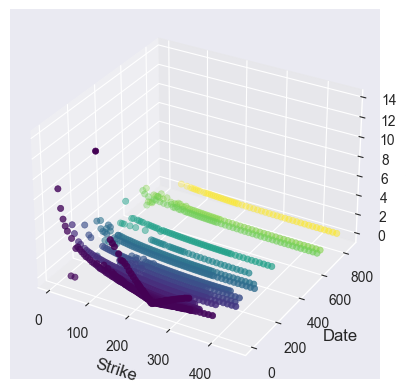

In [313]:
strikes = []
call_IVs = []
dates = []

for date, df in aapl_straddle_df_dict.items():
    strikes.extend(df['strike'].values)
    call_IVs.extend(df['call_IV'].values)
    dates.extend([date] * len(df))

dates = pd.Series([datetime.datetime.strptime(d, "%Y-%m-%d") for d in dates])
date_numbers = (dates - dates.min()).dt.days.to_numpy()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(strikes, date_numbers, call_IVs, c=date_numbers, cmap='viridis')

ax.set_xlabel('Strike')
ax.set_ylabel('Date')
ax.set_zlabel('Call IV')

plt.show()

ValueError: Argument Z must be 2-dimensional.

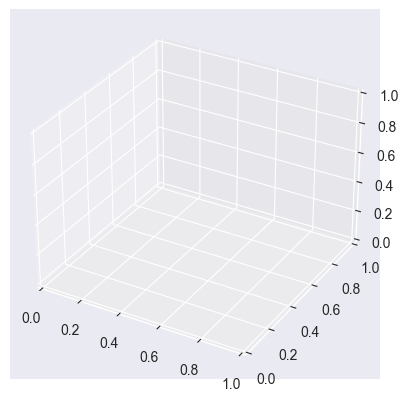

In [320]:
# Create a grid for the surface plot
strike_grid, date_grid = np.linspace(min(strikes), max(strikes), 100), np.linspace(min(date_numbers), max(date_numbers), 100)

# Use griddata for interpolation to create a smooth surface
call_IV_grid = griddata(
    (strikes, date_numbers), call_IVs, (strike_grid, date_grid), method='cubic'
)

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(strike_grid, date_grid, call_IV_grid, cmap='viridis', edgecolor='none')

# Set labels
ax.set_xlabel('Strike')
ax.set_ylabel('Date')
ax.set_zlabel('Call IV')

# Add a color bar
fig.colorbar(surf)

# Rotate the plot
ax.view_init(elev=30, azim=45)

# Show the plot
plt.show()

In [323]:
strike_grid

array([  5.        ,   9.49494949,  13.98989899,  18.48484848,
        22.97979798,  27.47474747,  31.96969697,  36.46464646,
        40.95959596,  45.45454545,  49.94949495,  54.44444444,
        58.93939394,  63.43434343,  67.92929293,  72.42424242,
        76.91919192,  81.41414141,  85.90909091,  90.4040404 ,
        94.8989899 ,  99.39393939, 103.88888889, 108.38383838,
       112.87878788, 117.37373737, 121.86868687, 126.36363636,
       130.85858586, 135.35353535, 139.84848485, 144.34343434,
       148.83838384, 153.33333333, 157.82828283, 162.32323232,
       166.81818182, 171.31313131, 175.80808081, 180.3030303 ,
       184.7979798 , 189.29292929, 193.78787879, 198.28282828,
       202.77777778, 207.27272727, 211.76767677, 216.26262626,
       220.75757576, 225.25252525, 229.74747475, 234.24242424,
       238.73737374, 243.23232323, 247.72727273, 252.22222222,
       256.71717172, 261.21212121, 265.70707071, 270.2020202 ,
       274.6969697 , 279.19191919, 283.68686869, 288.18

In [324]:
date_grid

array([  0.        ,   8.47474747,  16.94949495,  25.42424242,
        33.8989899 ,  42.37373737,  50.84848485,  59.32323232,
        67.7979798 ,  76.27272727,  84.74747475,  93.22222222,
       101.6969697 , 110.17171717, 118.64646465, 127.12121212,
       135.5959596 , 144.07070707, 152.54545455, 161.02020202,
       169.49494949, 177.96969697, 186.44444444, 194.91919192,
       203.39393939, 211.86868687, 220.34343434, 228.81818182,
       237.29292929, 245.76767677, 254.24242424, 262.71717172,
       271.19191919, 279.66666667, 288.14141414, 296.61616162,
       305.09090909, 313.56565657, 322.04040404, 330.51515152,
       338.98989899, 347.46464646, 355.93939394, 364.41414141,
       372.88888889, 381.36363636, 389.83838384, 398.31313131,
       406.78787879, 415.26262626, 423.73737374, 432.21212121,
       440.68686869, 449.16161616, 457.63636364, 466.11111111,
       474.58585859, 483.06060606, 491.53535354, 500.01010101,
       508.48484848, 516.95959596, 525.43434343, 533.90

In [321]:
call_IV_grid

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])